# Informer Demo

## Download code and dataset

In [3]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

fatal: destination path 'Informer2020' already exists and is not an empty directory.
fatal: destination path 'ETDataset' already exists and is not an empty directory.
drive  ETDataset  Informer2020	sample_data


In [4]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test i have trained and tested the ETTh1 dataset and input sequence length is 96 and predict future sequence length is 960


# **ETTh1 Dataset**

In [5]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [28]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 960 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.do_predict=True
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [29]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [30]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [31]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [32]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'ETTh1', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 960, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'do_predict': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [33]:
Exp = Exp_Informer

In [34]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftM_sl96_ll48_pl960_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7585
val 1921
test 1921
	iters: 100, epoch: 1 | loss: 0.5480239
	speed: 0.3499s/iter; left time: 462.9833s
	iters: 200, epoch: 1 | loss: 0.5288566
	speed: 0.3526s/iter; left time: 431.1939s
Epoch: 1 cost time: 83.34481716156006
Epoch: 1, Steps: 237 | Train Loss: 0.5732125 Vali Loss: 1.6104929 Test Loss: 1.1648067
Validation loss decreased (inf --> 1.610493).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.5260602
	speed: 0.6636s/iter; left time: 720.6363s
	iters: 200, epoch: 2 | loss: 0.4752430
	speed: 0.3511s/iter; left time: 346.2156s
Epoch: 2 cost time: 83.29278993606567
Epoch: 2, Steps: 237 | Train Loss: 0.4903888 Vali Loss: 1.6228317 Test Loss: 1.1484460
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.4876963
	speed: 0.6641s/iter

## PREDICTING THE FUTURE FORCASTE SEQUENCE

In [35]:
import os

# set saved model path
setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [36]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0
pred 1


In [37]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 960, 7)

In [41]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [42]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [43]:
len(data_set), len(data_loader)

(1, 1)

## Visualization

In [44]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((2848, 24, 7), (2848, 24, 7))

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

PLOT OF THE PREDICTION OF OT AND HUCL


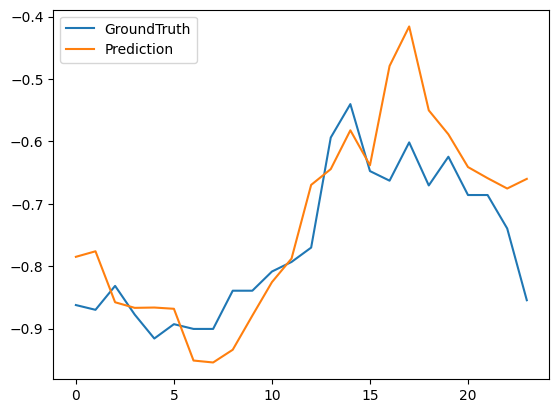

In [46]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

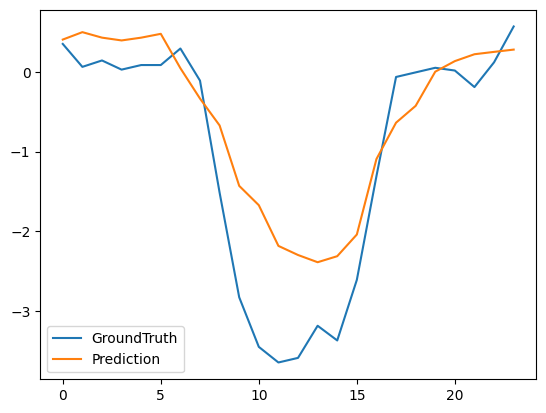

In [47]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

# ETTh2 DATASET

In [48]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh2' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 960 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.do_predict=True
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Exp = Exp_Informer

Args in experiment:
{'model': 'informer', 'data': 'ETTh2', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 960, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'do_predict': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [49]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()


Use GPU: cuda:0
>>>>>>>start training : informer_ETTh2_ftM_sl96_ll48_pl960_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7585
val 1921
test 1921
	iters: 100, epoch: 1 | loss: 0.5226523
	speed: 0.3261s/iter; left time: 431.4184s
	iters: 200, epoch: 1 | loss: 0.3829483
	speed: 0.3416s/iter; left time: 417.8212s
Epoch: 1 cost time: 79.8287181854248
Epoch: 1, Steps: 237 | Train Loss: 0.5028088 Vali Loss: 1.2221948 Test Loss: 2.3719475
Validation loss decreased (inf --> 1.222195).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.2928793
	speed: 0.6627s/iter; left time: 719.6545s
	iters: 200, epoch: 2 | loss: 0.3231390
	speed: 0.3544s/iter; left time: 349.4137s
Epoch: 2 cost time: 83.55777668952942
Epoch: 2, Steps: 237 | Train Loss: 0.3384398 Vali Loss: 1.4510168 Test Loss: 2.6688681
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.2472049
	speed: 0.6646s/iter;

In [55]:
# set saved model path
setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)



Use GPU: cuda:0


In [56]:
exp.predict(setting, True)

# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

pred 1


(1, 960, 7)

In [57]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

len(data_set), len(data_loader)

(1, 1)

In [58]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((2848, 24, 7), (2848, 24, 7))

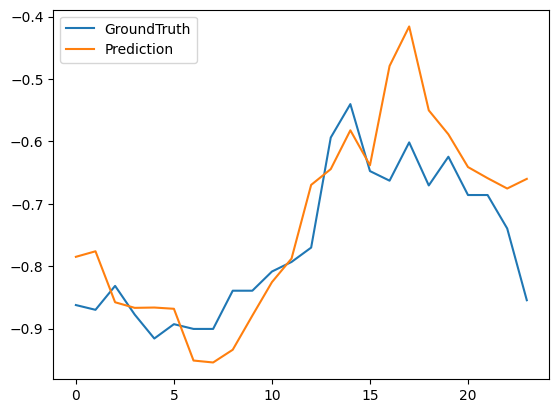

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

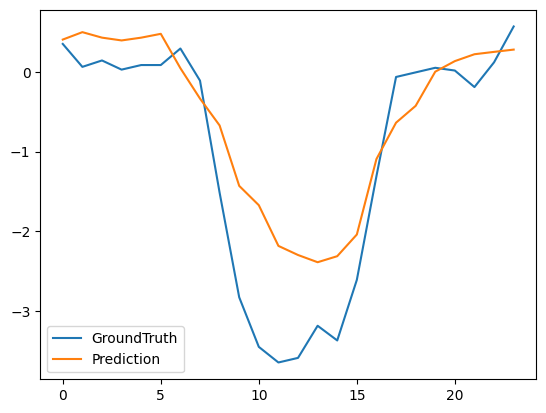

In [60]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **WEATHER DATASET**

In [77]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'WTH' # data
args.root_path = '/content/drive/MyDrive/LOLdataset/' # root path of data file
args.data_path = 'WTH.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 960 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.do_predict=True
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 1
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'WTH':{'data':'WTH.csv','T':'WetBulbCelsius','M':[12,12,12],'S':[1,1,1],'MS':[12,12,1]},
    'electricity':{'data':'electricity.csv','T':'MT_320','M':[321,321,321],'S':[1,1,1],'MS':[321,321,1]}
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Exp = Exp_Informer

Args in experiment:
{'model': 'informer', 'data': 'WTH', 'root_path': '/content/drive/MyDrive/LOLdataset/', 'data_path': 'WTH.csv', 'features': 'M', 'target': 'WetBulbCelsius', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 960, 'enc_in': 12, 'dec_in': 12, 'c_out': 12, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'do_predict': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 1, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [78]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_WTH_ftM_sl96_ll48_pl960_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 23489
val 2549
test 6053
	iters: 100, epoch: 1 | loss: 0.6368310
	speed: 0.3591s/iter; left time: 228.0411s
	iters: 200, epoch: 1 | loss: 0.5963416
	speed: 0.3612s/iter; left time: 193.2224s
	iters: 300, epoch: 1 | loss: 0.5916244
	speed: 0.3589s/iter; left time: 156.1088s
	iters: 400, epoch: 1 | loss: 0.6091633
	speed: 0.3536s/iter; left time: 118.4649s
	iters: 500, epoch: 1 | loss: 0.5750133
	speed: 0.3534s/iter; left time: 83.0585s
	iters: 600, epoch: 1 | loss: 0.5492865
	speed: 0.3523s/iter; left time: 47.5633s
	iters: 700, epoch: 1 | loss: 0.5560897
	speed: 0.3518s/iter; left time: 12.3144s
Epoch: 1 cost time: 261.2093577384949
Epoch: 1, Steps: 734 | Train Loss: 0.5930515 Vali Loss: 0.8121875 Test Loss: 0.5987756
Validation loss decreased (inf --> 0.812187).  Saving model ...
Updating learning rate to 0.0001
>>>>>>

In [79]:
exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0
pred 1


In [80]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape


(1, 960, 12)

In [81]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

len(data_set), len(data_loader)

(1, 1)

In [82]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((6048, 960, 12), (6048, 960, 12))

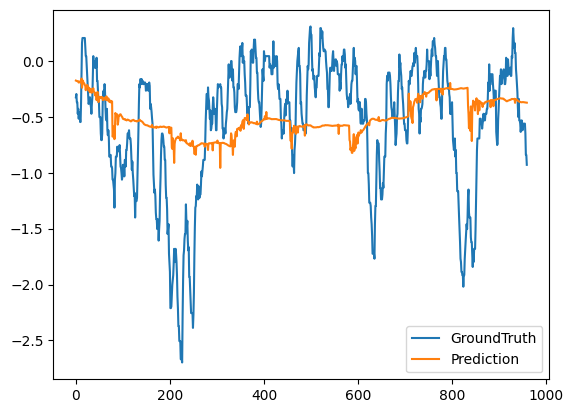

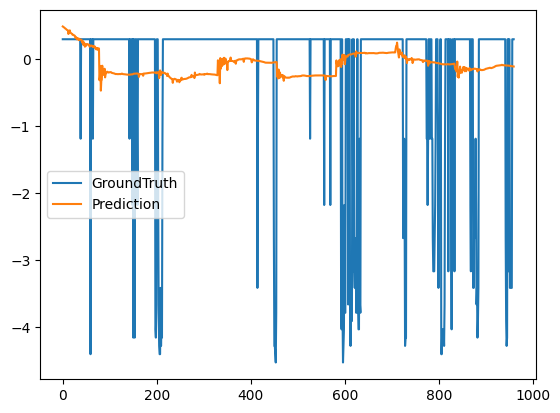

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()



# **ELECTRICITY DATASET **


In [6]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ECL' # data
args.root_path = '/content/drive/MyDrive/LOLdataset/' # root path of data file
args.data_path = 'ECL.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 960 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.do_predict=True
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 1
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'WTH':{'data':'WTH.csv','T':'WetBulbCelsius','M':[12,12,12],'S':[1,1,1],'MS':[12,12,1]},
    'ECL':{'data':'ECL.csv','T':'MT_320','M':[321,321,321],'S':[1,1,1],'MS':[321,321,1]}
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Exp = Exp_Informer

Args in experiment:
{'model': 'informer', 'data': 'ECL', 'root_path': '/content/drive/MyDrive/LOLdataset/', 'data_path': 'ECL.csv', 'features': 'M', 'target': 'MT_320', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 960, 'enc_in': 321, 'dec_in': 321, 'c_out': 321, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'do_predict': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 1, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_ECL_ftM_sl96_ll48_pl960_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 17357
val 1673
test 4301
	iters: 100, epoch: 1 | loss: 0.8752629
	speed: 0.6371s/iter; left time: 282.2515s
	iters: 200, epoch: 1 | loss: 0.8344861
	speed: 0.5368s/iter; left time: 184.1370s
	iters: 300, epoch: 1 | loss: 0.8484840
	speed: 0.5280s/iter; left time: 128.3027s
	iters: 400, epoch: 1 | loss: 0.8152073
	speed: 0.5476s/iter; left time: 78.3056s
	iters: 500, epoch: 1 | loss: 0.8091524
	speed: 0.5521s/iter; left time: 23.7399s
Epoch: 1 cost time: 302.91025733947754
Epoch: 1, Steps: 542 | Train Loss: 0.8501918 Vali Loss: 0.7779360 Test Loss: 0.9224904
Validation loss decreased (inf --> 0.777936).  Saving model ...
Updating learning rate to 0.0001
>>>>>>>testing : informer_ECL_ftM_sl96_ll48_pl960_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 4301


In [7]:
 # test
setting='informer_ECL_ftM_sl96_ll48_pl960_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp = Exp(args)
#exp.test(setting)
torch.cuda.empty_cache()

>>>>>>>testing : informer_ECL_ftM_sl96_ll48_pl960_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Use GPU: cuda:0


PREDICTING FUTURE FORECAST

In [ ]:


exp.predict(setting, True)

# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

In [ ]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

len(data_set), len(data_loader)

In [ ]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

In [ ]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()
